In [1]:
import numpy as np
from keras import models;

In [2]:
get_model_directory = lambda series, cut: f"models/{series}_series/{cut}_cut/"
get_model_name = lambda number: f"m_{number}.h5"

In [3]:
series_number = 4

def get_model(cut_num, number):
    model_name = get_model_directory(series_number, cut_num) + get_model_name(number)
    return models.load_model(model_name, compile = False)  

In [4]:
from gtda.homology import VietorisRipsPersistence

In [5]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(matrix):
    n = matrix.shape[1]
    cos = lambda a, b: dot(a, b) / (norm(a) * norm(b))
    
    new_matrix = np.zeros([n, n])

    for i in range(n):
        for j in range(i+1):
            new_matrix[i, j] = 1 - cos(matrix[:, i], matrix[:, j])
            new_matrix[j, i] = new_matrix[i, j]

    return new_matrix

def model_cos(model, layer_num):
    layers = model.layers
    weight_matrix = layers[layer_num].get_weights()[0]
    return cosine_similarity(weight_matrix)

In [6]:
VR = VietorisRipsPersistence(metric="precomputed")

In [7]:
def analyse_model(cut, num):
    model = get_model(cut, num)
    X = [model_cos(model, i) for i in range(len(model.layers) - 1)]
    return VR.fit_transform(X)

In [8]:
from gtda.plotting import plot_diagram

In [9]:
cuts = [1, 2, 4, 8, 16, 32, 64, 128, 254, 1024, 2048]

In [ ]:
# cuts = [1, 2, 3, 4, 5, 6, 7, 16, 32, 64, 128, 200, 300, 400, 512, 670]

In [12]:
tries = 20
def get_all_diagrams_from(cut):
    all = [analyse_model(cut, num) for num in range(tries)]
    return [[all[i][layer] for i in range(tries)] for layer in range(3)] 

In [13]:
def get_diagrams_overall(): 
    return [get_all_diagrams_from(c) for c in cuts]

In [14]:
all_diagrams = get_diagrams_overall()

In [15]:
from gtda.diagrams import PersistenceEntropy

In [16]:
import matplotlib.pyplot as plt

In [17]:
def draw_box_plot(fun, layer, dim, showfliers = True):
    fig = plt.figure(figsize =(7, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    y = fun(layer, dim)
    bp = ax.boxplot(y, showfliers=showfliers)

# Энтропия

In [18]:
persistence = PersistenceEntropy(normalize=False)

def persistent_entropy(layer, dim):
    persistence = PersistenceEntropy(normalize=True)
    return [np.array([persistence.fit_transform([all_diagrams[c][layer][i]])[0][dim] 
                      for i in range(tries)]) 
                      for c in range(len(cuts))]

def draw_entropy(layer, dim, showfliers = True):
    draw_box_plot(persistent_entropy, layer, dim, showfliers=showfliers)
    

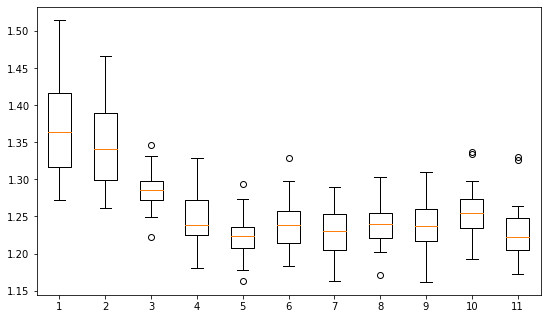

In [19]:
draw_entropy(0,0)

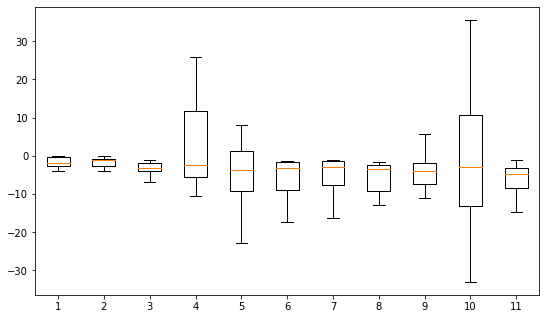

In [20]:
draw_entropy(0,1, showfliers=False)

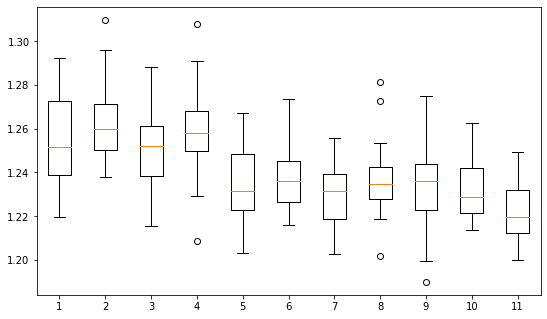

In [21]:
draw_entropy(1, 0)

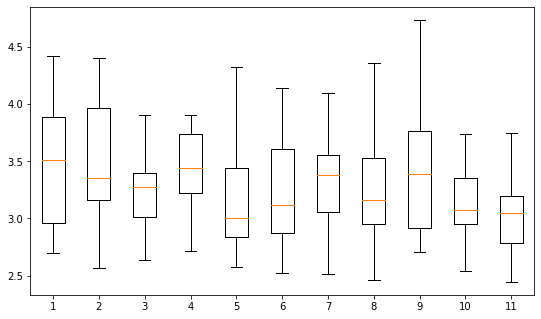

In [22]:
draw_entropy(1, 1, showfliers=False)

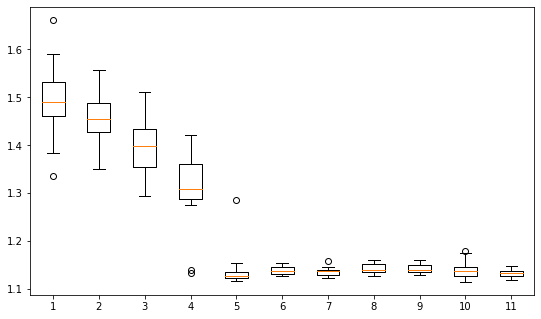

In [23]:
draw_entropy(2, 0)

# Число гомологий

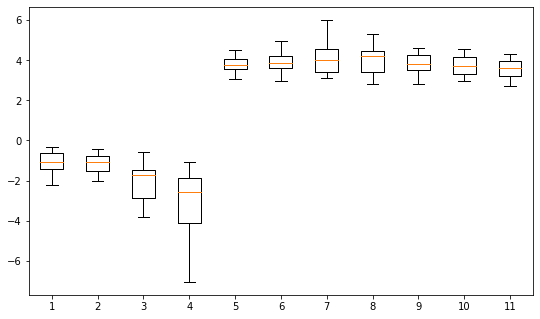

In [24]:
draw_entropy(2, 1, showfliers=False)

In [25]:
from gtda.diagrams import NumberOfPoints

In [26]:
number_of_points = NumberOfPoints()

def homology_by_layer(layer, dim):
    return [np.array([number_of_points.fit_transform([all_diagrams[cut][layer][t]])[0][dim] for t in range(tries)]) for cut in range(len(cuts))]

In [27]:
def draw_number_of_points(layer, dim):
    draw_box_plot(homology_by_layer, layer, dim)

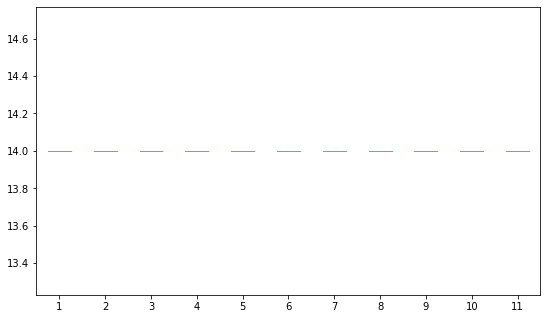

In [28]:
draw_number_of_points(0, 0)

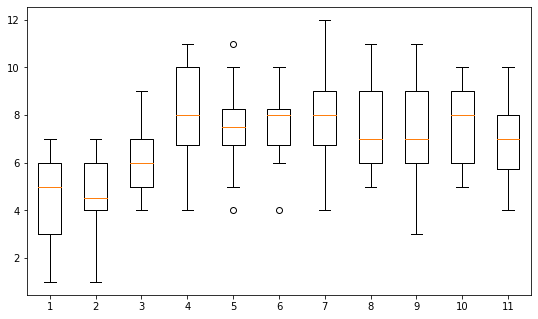

In [29]:
draw_number_of_points(0, 1)

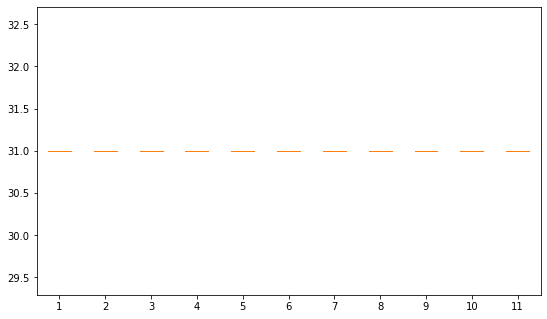

In [30]:
draw_number_of_points(1, 0)

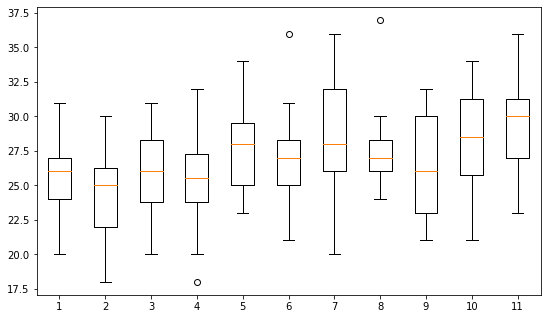

In [31]:
draw_number_of_points(1, 1)

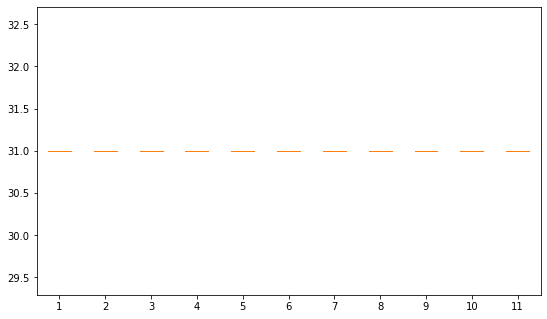

In [32]:
draw_number_of_points(2, 0)

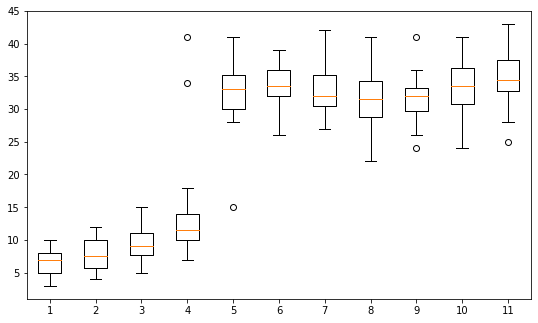

In [33]:
draw_number_of_points(2, 1)

In [34]:
def life_time(diagram, dim):
    return sum([i[1] - i[0] for i in diagram if i[2] == dim])

def left_bound(diagram, dim):
    return min(i[0] for i in diagram if i[2] == dim)

def right_bound(diagram, dim):
    return max(i[1] for i in diagram if i[2] == dim)

def mean_life_time(diagram, dim):
    l = life_time(diagram, dim)
    l, r = left_bound(diagram, dim), right_bound(diagram, dim)
    assert(r > l)

    return l / (r - l)

def life_time_by_layer(layer, dim):
    return [[life_time(all_diagrams[cut][layer][t], dim) for t in range(tries)] for cut in range(len(cuts))]

def mean_life_time_by_layer(layer, dim):
    return [[mean_life_time(all_diagrams[cut][layer][t], dim) for t in range(tries)] for cut in range(len(cuts))]

def draw_life_time(layer, dim):
    draw_box_plot(life_time_by_layer, layer, dim)

def draw_mean_life(layer, dim):
    draw_box_plot(mean_life_time_by_layer, layer, dim)

# Усредненная продолжительность жизни

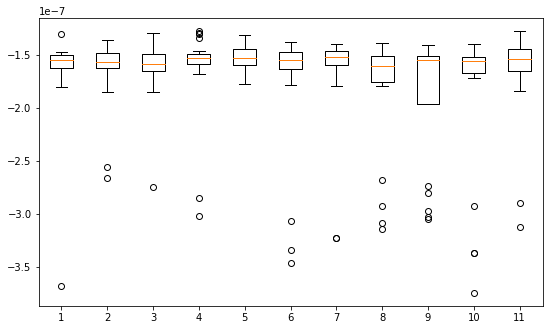

In [35]:
draw_mean_life(0,0)

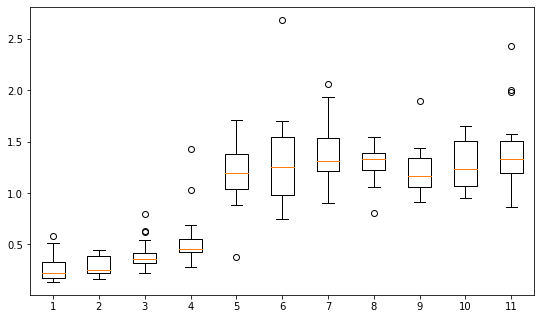

In [36]:
draw_mean_life(0,1)

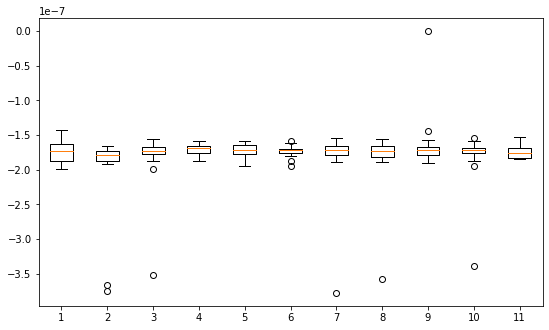

In [37]:
draw_mean_life(1,0)

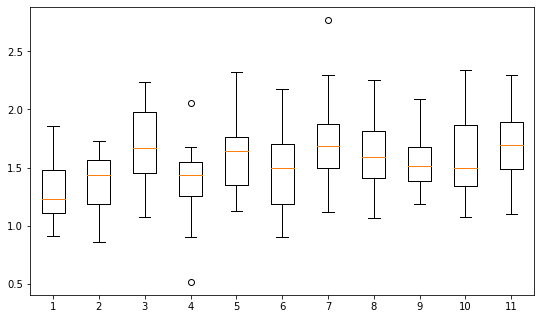

In [38]:
draw_mean_life(1,1)

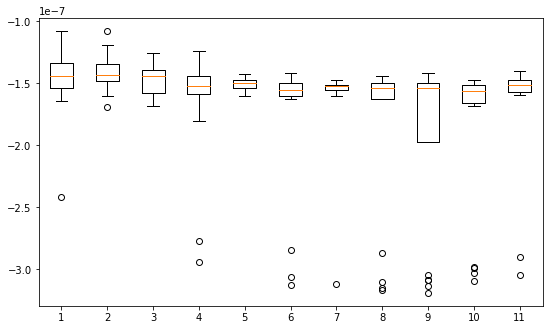

In [39]:
draw_mean_life(2,0)

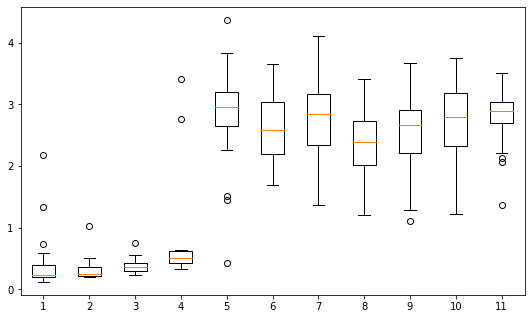

In [40]:
draw_mean_life(2,1)

# Полная продолжительность жизни

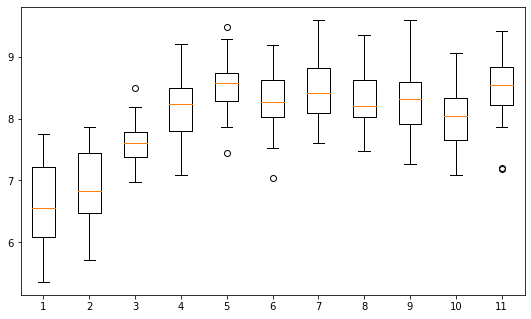

In [41]:
draw_life_time(0, 0)

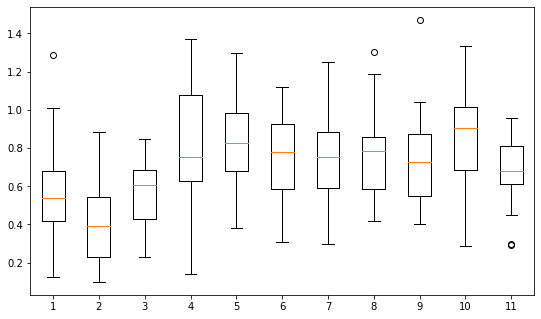

In [42]:
draw_life_time(0, 1)

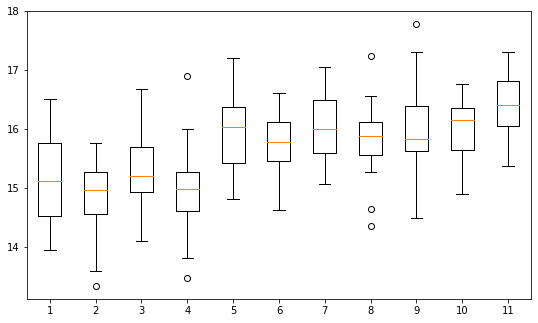

In [43]:
draw_life_time(1, 0)

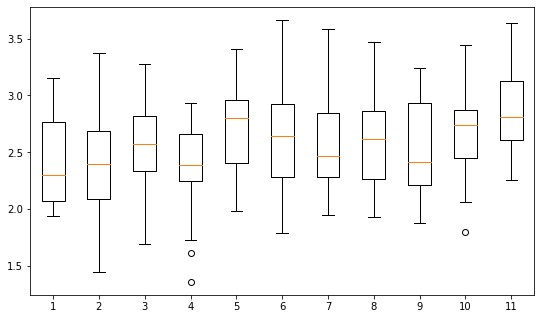

In [44]:
draw_life_time(1, 1)

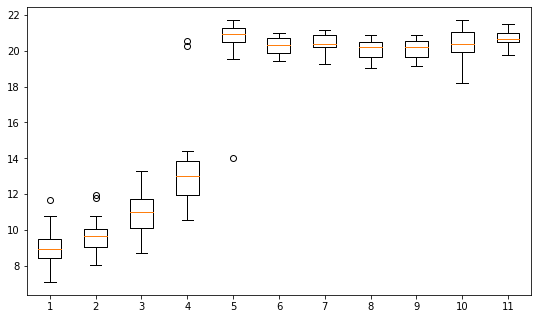

In [45]:
draw_life_time(2, 0)

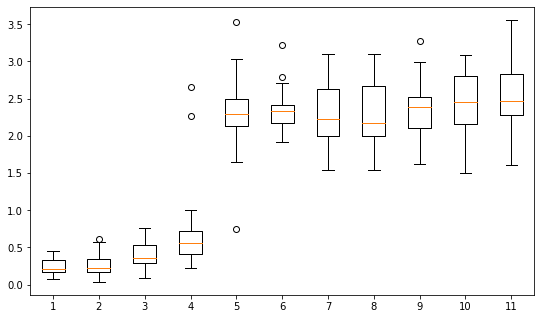

In [46]:
draw_life_time(2, 1)

# Случайная матрица

In [56]:
dispersion_list  = np.linspace(1, 10, 9)

In [57]:
def t(c): return np.sqrt(3)*c

In [59]:
r_size = 30
r_tries = 30

In [60]:
all_random_diagrams = [[VR.fit_transform([np.random.uniform(-t(cut), t(cut), size=(r_size, r_size))]) 
                        for _ in range(r_tries)] 
                       for cut in dispersion_list] 

In [61]:
persistence = PersistenceEntropy(normalize=True)

In [62]:
def draw_r_entropy(dim):
    draw_box_plot(lambda x, y: [np.array([persistence.fit_transform([all_random_diagrams[cut][t][0]])[0][dim] 
                            for t in range(r_tries)]) 
                            for cut in range(len(dispersion_list))], 0, 0)

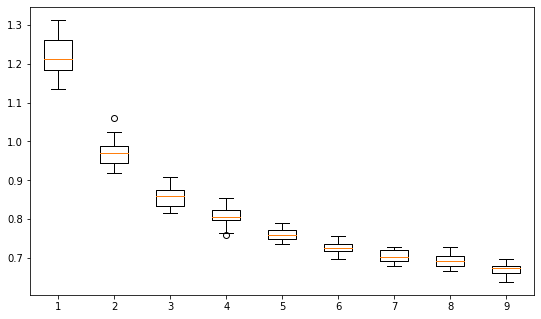

In [63]:
draw_r_entropy(1)

In [64]:
def draw_r_life_time(dim, showfliers=True):
    draw_box_plot(lambda x, y: [np.array([life_time(all_random_diagrams[cut][t][0], dim) 
                            for t in range(r_tries)]) 
                            for cut in range(len(dispersion_list))], 0, 0, showfliers=showfliers)

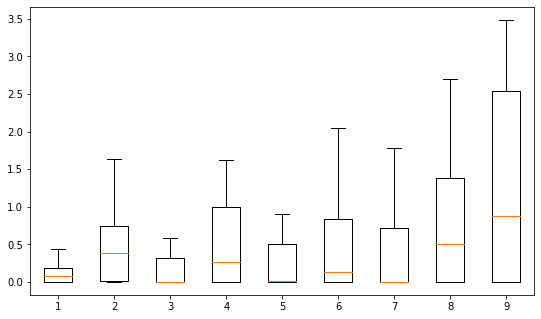

In [65]:
draw_r_life_time(0, showfliers=False)

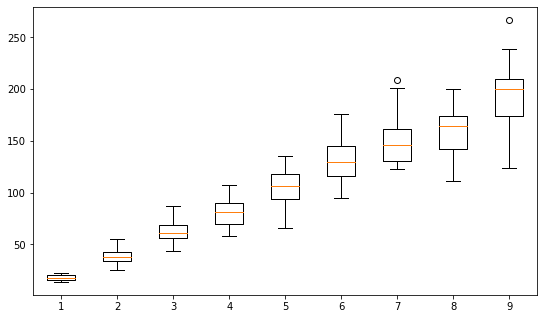

In [66]:
draw_r_life_time(1)